In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

# MODEL AND GEOM DEFINITON

In [4]:
# Velocity Model
nx, nz = 301, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Microseismic source
xmicro = [nx//2, nx//4]
zmicro = [nz//2, nz//4]
ampmicro = [1, 4]
microseismic = np.zeros((nx, nz))
for ix, iz, amp in zip(xmicro, zmicro, ampmicro):
    microseismic[ix, iz] = amp

# Receivers
nr = 11
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]



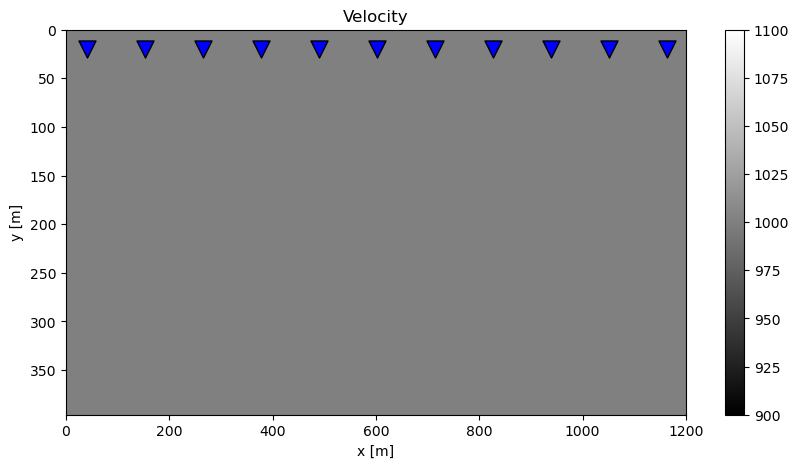

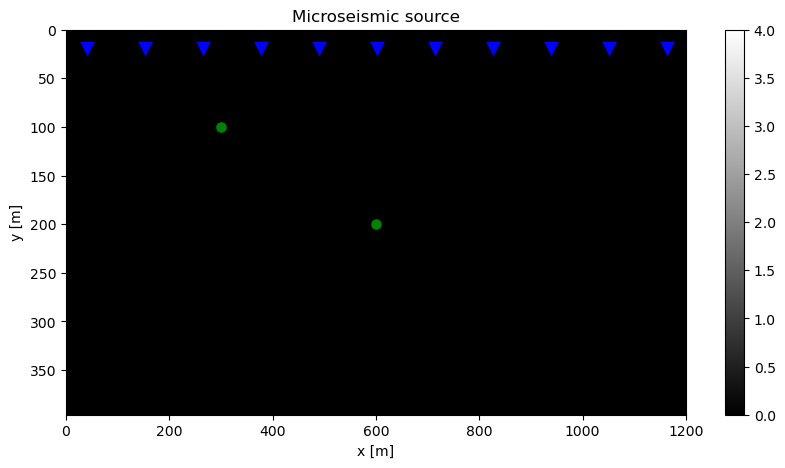

In [5]:
plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(microseismic.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(x[xmicro], z[zmicro], marker='.', s=300, c='g', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Microseismic source')
plt.xlim(x[0], x[-1]);

# COMPUTE TRAVELTIMES

In [6]:
trav = Kirchhoff._traveltime_table(z, x, recs, recs, v0, mode='analytic')[1]


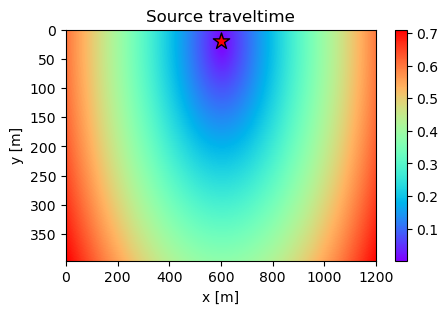

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
im = ax.imshow(trav[:, nr//2].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, nr//2], recs[1, nr//2], marker='*', s=150, c='r', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Source traveltime')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

# MODEL THE DATA

In [8]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, nr)
travd = travd.reshape(nx, nz, nr)


In [9]:
# create operator
sop = Spread(dims=(nx, nz), dimsd=(nr, nt),
             table=itrav, dtable=travd, engine='numba')

cop = Convolve1D(h=wav, offset=wavc,
                 dims=(nr, nt), axis=1)
Demop = cop * sop


d = Demop * microseismic.ravel()
d = d.reshape(nr, nt)

madj = Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsqr(Demop, d.ravel(), iter_lim=100, show=True)[0]
minv = minv.reshape(nx, nz)

minv_sparse = fista(Demop, d.ravel(), niter=100, eps=1e1, show=True)[0]
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = Demop * madj.ravel()
dadj = dadj.reshape(nr, nt)

dinv = Demop * minv.ravel()
dinv = dinv.reshape(nr, nt)

dinv_sparse = Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(nr, nt)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 7161 rows and 30100 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.638e+01  2.638e+01    1.0e+00  2.5e+00
     1 -5.20601e-04   1.575e+01  1.575e+01    6.0e-01  6.5e-01   8.2e+01  1.0e+00
     2 -1.59392e-03   1.016e+01  1.016e+01    3.9e-01  4.6e-01   1.1e+02  2.3e+00
     3 -2.51566e-03   7.478e+00  7.478e+00    2.8e-01  2.9e-01   1.4e+02  3.7e+00
     4 -2.64552e-03   5.699e+00  5.699e+00    2.2e-01  2.4e-01   1.6e+02  5.3e+00
     5 -2.84195e-03   4.523e+00  4.523e+00    1.7e-01  1.8e-01   1.8e+02  7.0e+00
     6 -2.82997e-03   3.786e+00  3.786e+00    1.4e-01  1.6e-01   2.0e+02  8.7e+00
     7 -2.66608e-03   3.236e+00  3.236e+00    1.2e-01  1.4e-01   2.1e+02  1.1e+01
     8 -2.69278e-03   2.783e+00  

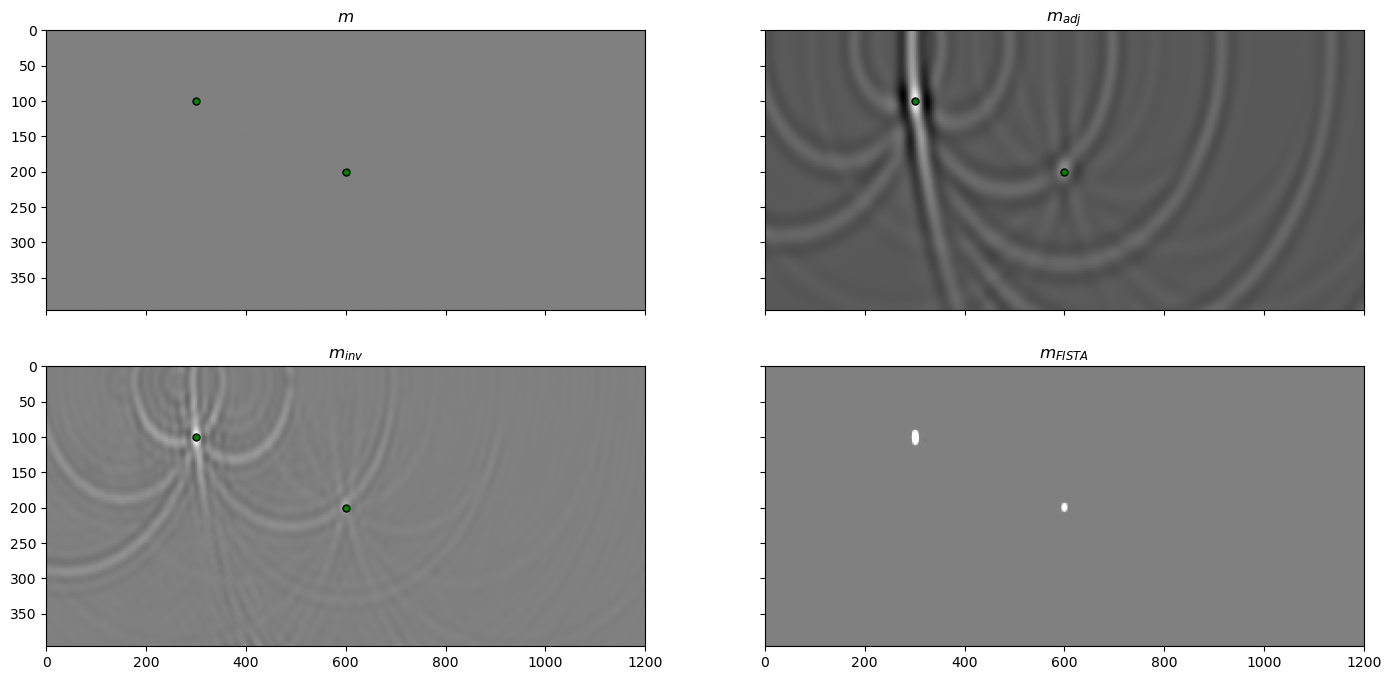

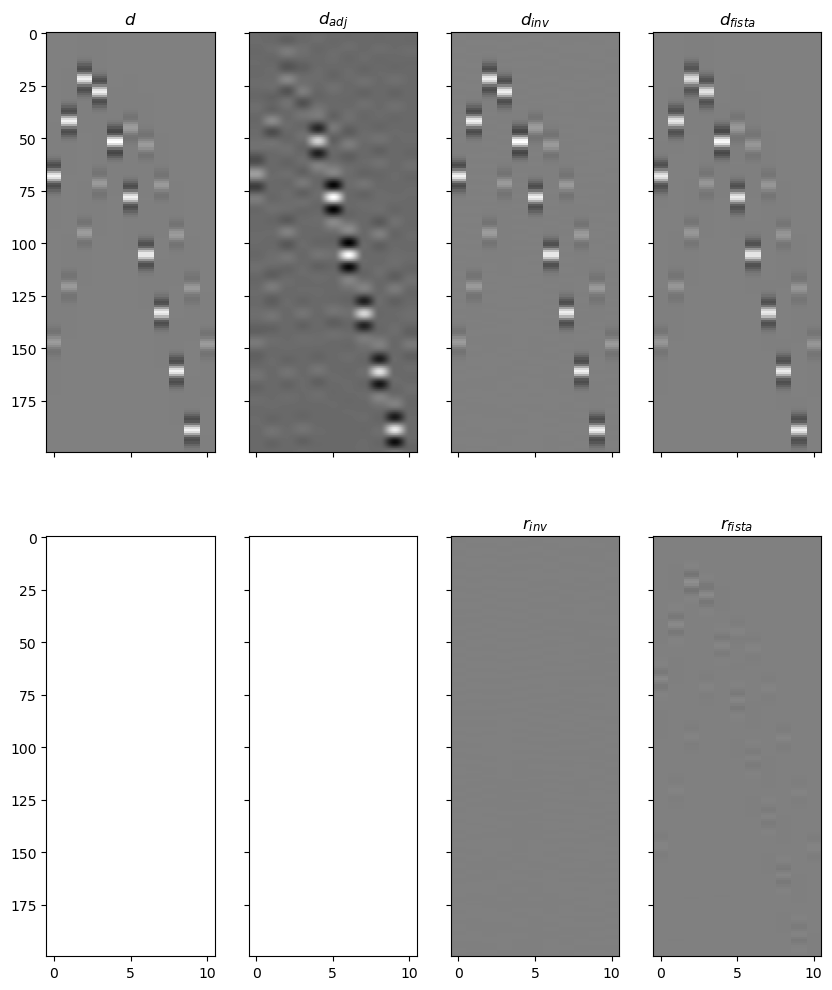

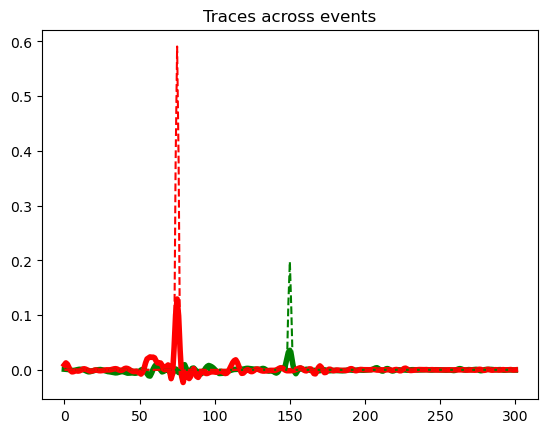

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(17, 8), sharey=True, sharex=True)
axs[0][0].imshow(microseismic.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
axs[0][0].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
axs[0][1].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
axs[1][0].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
#axs[1][1].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(2, 4, figsize=(10, 12), sharey=True, sharex=True)
axs[0][0].imshow(d[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[0][0].set_title(r'$d$')
axs[0][0].axis('tight')
axs[0][1].imshow(dadj[:, :200].T, cmap='gray')
axs[0][1].set_title(r'$d_{adj}$')
axs[0][1].axis('tight')
axs[0][2].imshow(dinv[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[0][2].set_title(r'$d_{inv}$')
axs[0][2].axis('tight');
axs[0][3].imshow(dinv_sparse[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[0][3].set_title(r'$d_{fista}$')
axs[0][3].axis('tight');
axs[1][2].imshow(d[:, :200].T-dinv[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[1][2].set_title(r'$r_{inv}$')
axs[1][2].axis('tight');
axs[1][3].imshow(d[:, :200].T-dinv_sparse[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[1][3].set_title(r'$r_{fista}$')
axs[1][3].axis('tight')

plt.figure()
plt.plot(minv[:, zmicro[0]], 'g', lw=4)
plt.plot(minv[:, zmicro[1]], 'r', lw=4)
plt.plot(minv_sparse[:, zmicro[0]], '--g')
plt.plot(minv_sparse[:, zmicro[1]], '--r')
plt.title('Traces across events');